<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/personal_project_animal_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our classification task in the animals.
We get very high accuracy after using transfer learning.(around98%)


In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

import os

from pathlib import Path
import requests
import zipfile

data_path=Path("data_set")

2.3.1+cu121


In [2]:
!git clone https://github.com/kavishsanghvi/fauna-image-classification-using-convolutional-neural-network.git

if not data_path.is_dir():

    data_path.mkdir(parents=True,exist_ok=True)
    !cp -av /content/fauna-image-classification-using-convolutional-neural-network/data/train /content/data_set
    !cp -av /content/fauna-image-classification-using-convolutional-neural-network/data/validation /content/data_set


    !cp -av /content/fauna-image-classification-using-convolutional-neural-network/data/test /content/data_set

    !rm -r /content/fauna-image-classification-using-convolutional-neural-network


Cloning into 'fauna-image-classification-using-convolutional-neural-network'...
remote: Enumerating objects: 17032, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 17032 (delta 13), reused 11 (delta 3), pack-reused 17002
Receiving objects: 100% (17032/17032), 329.97 MiB | 32.94 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (17820/17820), done.


In [3]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
# Setup train and testing paths
train_paths=data_path/"train"
test_paths=data_path/"test"
val_paths=data_path/"validation"
whole_paths=data_path
walk_through_dir(test_paths)
list_path=list(whole_paths.glob("*/*/*.jpeg"))

There are 6 directories and 0 images in 'data_set/test'.
There are 0 directories and 203 images in 'data_set/test/chickens'.
There are 0 directories and 472 images in 'data_set/test/horses'.
There are 0 directories and 152 images in 'data_set/test/elephants'.
There are 0 directories and 244 images in 'data_set/test/squirells'.
There are 0 directories and 371 images in 'data_set/test/butterflies'.
There are 0 directories and 403 images in 'data_set/test/spiders'.


200 300


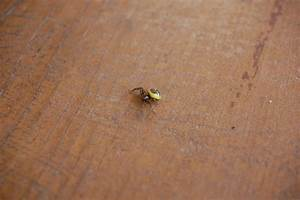

In [5]:
# Do the image visualization with matplotlib

import random
from PIL import Image

radom_path=random.choice(list_path)
radom_path.parent.stem

img=Image.open(radom_path)



print(img.height,img.width)

img

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [7]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [9]:
# Write a function to plot transformed images
import matplotlib.pyplot as plt


def plot_image(image_path_list,transform,n=3):
  random_path=random.sample(image_path_list,k=3)

  for i in random_path:
    fig,ax=plt.subplots(1,2)
    img=Image.open(i)
    ax[0].imshow(img)

    transform_img=transform(img)
    ax[0].set_title(f"shape{img.height,img.width}")
    ax[0].axis("off")
    ax[1].imshow(transform_img.permute(1,2,0))
    ax[1].set_title(f"shape{transform_img.permute(1,2,0).shape}")
    ax[1].axis("off")






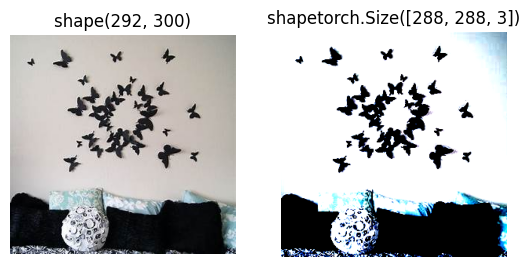

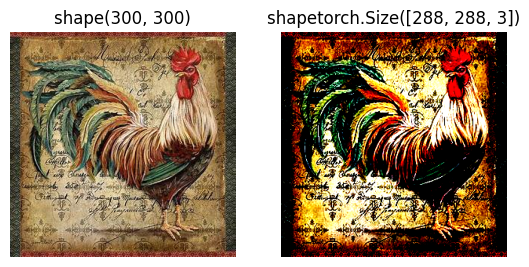

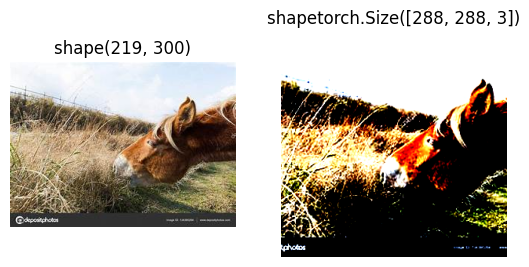

In [10]:
import torch

import torchvision



device= "cuda" if torch.cuda.is_available() else "cpu"


weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_0=torchvision.models.efficientnet_b2(weights=weights).to(device)

for param in model_0.features.parameters():
    param.requires_grad = False

model_0.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=6, # same number of output units as our number of classes
                    bias=True)).to(device)

data_transform=weights.transforms()


plot_image(list_path,data_transform,n=3)



In [11]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [12]:
import os

for i in list(os.listdir(test_paths)):
  if (i[-1:-4:-1])=="gpj" or (i[-1:-5:-1])=="gepj" :
      os.remove(str(test_paths)+"/"+i)

classes=sorted([i.name for i in list (os.scandir(test_paths))])

classes_train=sorted([i.name for i in list (os.scandir(train_paths))])

{ classes[i]: i for i in range(len(classes))},{ classes_train[i]: i for i in range(len(classes_train))}




({'butterflies': 0,
  'chickens': 1,
  'elephants': 2,
  'horses': 3,
  'spiders': 4,
  'squirells': 5},
 {'butterflies': 0,
  'chickens': 1,
  'elephants': 2,
  'horses': 3,
  'spiders': 4,
  'squirells': 5})

### Load image data using `ImageFolder`

In [13]:

from torch.utils.data import Dataset
from torchvision import datasets,transforms
import random
from PIL import Image

def data_creator(train_path=train_paths,test_path=test_paths,val_path=val_paths,transform1=data_transform,batch_size=32,num_worker=os.cpu_count()):
  class customdata(Dataset):
    def __init__(self,paths,transform=transform1):
      self.list_file=sorted(list(paths.glob("*/*.jpeg")))
      self.transform=transform
      self.paths=paths


      self.class_names=sorted([i.name for i in list (os.scandir(paths))])
      self.class_toidx=self.class_to_idx()
    def __len__(self):
      return len(list(self.list_file))

    def print_image(self,index):
      img=Image.open(self.list_file[index])

      return img

    def class_to_idx(self):
      classes=self.class_names

      return { classes[i]: i for i in range(len(classes))}


    def __getitem__(self,index):
      image1=self.print_image(index)

      indexes=self.class_to_idx()

      name_withindex=self.list_file[index].parent.stem




      index1=indexes[name_withindex]

      if self.transform:
        return (self.transform(image1),index1)
      else:
        return image1,index1

  def class_to_idx(path):
    classes=sorted([i.name for i in list (os.scandir(path))])

    return { classes[i]: i for i in range(len(classes))}

# Can also get class names as a dict



  train_data=customdata(train_path,transform1)
  test_data=customdata(test_path,transform1)
  val_data=customdata(val_path,transform1)
  train_val_sets = torch.utils.data.ConcatDataset([train_data, val_data])

  classes=sorted([i.name for i in list (os.scandir(test_path))])

  from torch.utils.data import DataLoader

  #train_loader=DataLoader(train_val_sets,batch_size,True,num_workers)
  train_loader=DataLoader(train_val_sets,32,True,num_workers=num_worker)
  test_loader=DataLoader(test_data,batch_size,False,num_workers=num_worker)

  return train_loader,test_loader,classes,class_to_idx(test_paths)


In [14]:
train_loader,test_loader,class_names,class_index=data_creator()
train_loader,test_loader,class_names,class_index,len(train_loader),len(test_loader)

(<torch.utils.data.dataloader.DataLoader at 0x7e2d3ada6c80>,
 ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
 {'butterflies': 0,
  'chickens': 1,
  'elephants': 2,
  'horses': 3,
  'spiders': 4,
  'squirells': 5},
 460,
 58)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [15]:
try:
  import torchinfo
except:
  ! pip install torchinfo
  import torchinfo

from torchinfo import summary


summary(model_0,input_size=[1,3,200,200],verbose=0)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 6]                    --
├─Sequential: 1-1                                       [1, 1408, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 100, 100]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 100, 100]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 100, 100]         --
│    └─Sequential: 2-2                                  [1, 16, 100, 100]         --
│    │    └─MBConv: 3-4                                 [1, 16, 100, 100]         (1,448)
│    │    └─MBConv: 3-5                                 [1, 16, 100, 100]         (612)
│    └─Sequential: 2-3                                  [1, 24, 50, 50]           --
│    │    └─MBConv: 3-6                        

## 4. Create training and testing functions for `model_0`.

In [16]:
import os
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for X,y in dataloader:
    # Send data to target device
    X=X.to(device)
    y=y.to(device)
    # 1. Forward pass
    y_logit=model(X)

    y_pred=torch.softmax(y_logit,-1).argmax(-1)
    # 2. Calculate and accumulate loss
    loss=loss_fn(y_logit,y)  #average lost for one batch
    train_loss=train_loss+loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_acc=train_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  train_acc=train_acc/len(dataloader)
  train_loss=train_loss/len(dataloader)

  return (train_loss,train_acc)

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,device=device):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for X,y in dataloader:
    # Send data to target device
      X=X.to(device)
      y=y.to(device)
    # 1. Forward pass
      y_logit=model(X)

      y_pred=torch.softmax(y_logit,-1).argmax(-1)



      # 2. Calculuate and accumulate loss
      loss=loss_fn(y_logit,y)  #average lost for one batch
      test_loss=test_loss+loss

      test_acc=test_acc+torch.sum(y_pred==y).item()/len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  test_acc=test_acc/len(dataloader)
  test_loss=test_loss/len(dataloader)

  return (test_loss,test_acc)

      # Calculate and accumulate accuracy


  # Adjust metrics to get average loss and accuracy per batch

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results


In [ ]:
model_0(test_one)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)



## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [ ]:
# Train for 5 epochs
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(model_0,train_loader,test_loader,optimizer,loss_fn)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2437 | train_acc: 0.9404 | test_loss: 0.0915 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.1194 | train_acc: 0.9631 | test_loss: 0.0782 | test_acc: 0.9801
Epoch: 3 | train_loss: 0.0989 | train_acc: 0.9696 | test_loss: 0.0676 | test_acc: 0.9806
Epoch: 4 | train_loss: 0.0966 | train_acc: 0.9697 | test_loss: 0.0672 | test_acc: 0.9795
Epoch: 5 | train_loss: 0.0898 | train_acc: 0.9725 | test_loss: 0.0627 | test_acc: 0.9822


{'train_loss': [tensor(0.2437, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.1194, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0989, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0966, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.0898, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.9403903162055336,
  0.963086709486166,
  0.969633152173913,
  0.9697010869565217,
  0.9724555335968379],
 'test_loss': [tensor(0.0915, device='cuda:0'),
  tensor(0.0782, device='cuda:0'),
  tensor(0.0676, device='cuda:0'),
  tensor(0.0672, device='cuda:0'),
  tensor(0.0627, device='cuda:0')],
 'test_acc': [0.9792436371100164,
  0.9800646551724138,
  0.9806034482758621,
  0.9795258620689655,
  0.9822198275862069]}

Our model is not overfitted and the transfer learning performs very well

Use the model where there is not transfer learning:

In [45]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data import Dataset
import random
from PIL import Image
from pathlib import Path
import requests
import zipfile
class vggmodel(nn.Module):
  def __init__(self,in_feature,hidden1,hidden2,hidden3,hidden4,hidden5,hidden6,linear1,linear2,out_feature):
    super().__init__()
    self.block_1=nn.Sequential(nn.Conv2d(in_feature,hidden1,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden1,hidden2,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))
    self.block_2=nn.Sequential(nn.Conv2d(hidden2,hidden3,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden3,hidden4,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))
    self.block_3=nn.Sequential(nn.Conv2d(hidden4,hidden5,kernel_size=3),nn.ReLU(),nn.Conv2d(hidden5,hidden6,kernel_size=3),nn.ReLU(),nn.MaxPool2d(2))

    self.last=nn.Sequential(nn.Flatten(),nn.Linear(14112,out_feature))

  def forward(self,x):
    return self.last(self.block_3(self.block_2(self.block_1(x))))





model_1=vggmodel(3,128,64,64,32,32,32,16,16,6)
model_1=model_1.to(device)



In [30]:
model_0(test_one)

tensor([[ 0.0992,  0.0239, -0.1421, -0.1499, -0.1682, -0.1567],
        [-0.1357, -0.0452,  0.0216, -0.0873,  0.1598,  0.3644],
        [ 0.0715,  0.0641,  0.1584,  0.0558,  0.0435,  0.0860],
        [-0.0378,  0.1915, -0.0046,  0.1532,  0.0063, -0.0628],
        [-0.0163, -0.0580, -0.2043, -0.2102,  0.3658,  0.1629],
        [ 0.0013, -0.0723,  0.1084, -0.4101,  0.3532,  0.3043],
        [ 0.1262, -0.0883,  0.1278, -0.1961,  0.1466,  0.1648],
        [ 0.1184, -0.3679, -0.1340, -0.5057,  0.3571,  0.2259],
        [ 0.1116, -0.0544, -0.0047,  0.0494,  0.2076,  0.1022],
        [-0.2262,  0.3266, -0.1102, -0.0458, -0.0600,  0.3200],
        [ 0.0729, -0.2330,  0.2013, -0.1024,  0.3784, -0.1008],
        [ 0.0490, -0.0687, -0.2615, -0.2529,  0.3885,  0.0277],
        [ 0.3039,  0.1012, -0.0060, -0.1609,  0.2759,  0.0356],
        [ 0.0140,  0.1134,  0.5318, -0.2467,  0.2792,  0.1540],
        [ 0.0753,  0.1242, -0.1431, -0.5841, -0.1474,  0.0563],
        [ 0.2860,  0.2163,  0.0403, -0.0

In [31]:
test_one.shape

torch.Size([32, 3, 288, 288])

In [46]:
try:
  import torchinfo
except:
  ! pip install torchinfo
  import torchinfo

from torchinfo import summary

data_transform2 = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(200, 200)),
    # Flip the images randomly on the horizontal
    transforms.TrivialAugmentWide(num_magnitude_bins=8), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

train_loader,test_loader,class_names,class_index=data_creator(transform1=data_transform2)
train_loader,test_loader,class_names,class_index,len(train_loader),len(test_loader)
test_one=next(iter(train_loader))[0]



In [47]:
model_1(test_one)

tensor([[ 0.0064,  0.0277,  0.0122,  0.0385, -0.0079,  0.0148],
        [ 0.0062,  0.0275,  0.0124,  0.0390, -0.0071,  0.0150],
        [ 0.0059,  0.0276,  0.0123,  0.0386, -0.0076,  0.0159],
        [ 0.0069,  0.0269,  0.0121,  0.0388, -0.0068,  0.0146],
        [ 0.0075,  0.0275,  0.0124,  0.0394, -0.0068,  0.0150],
        [ 0.0076,  0.0286,  0.0122,  0.0392, -0.0060,  0.0157],
        [ 0.0072,  0.0279,  0.0130,  0.0393, -0.0065,  0.0150],
        [ 0.0070,  0.0276,  0.0128,  0.0389, -0.0062,  0.0149],
        [ 0.0050,  0.0262,  0.0123,  0.0381, -0.0078,  0.0146],
        [ 0.0066,  0.0275,  0.0125,  0.0390, -0.0073,  0.0155],
        [ 0.0069,  0.0276,  0.0118,  0.0391, -0.0064,  0.0154],
        [ 0.0073,  0.0274,  0.0120,  0.0385, -0.0073,  0.0149],
        [ 0.0074,  0.0278,  0.0122,  0.0389, -0.0067,  0.0139],
        [ 0.0063,  0.0279,  0.0123,  0.0394, -0.0056,  0.0151],
        [ 0.0070,  0.0277,  0.0125,  0.0400, -0.0071,  0.0148],
        [ 0.0073,  0.0281,  0.0124,  0.0

In [58]:


summary(model_1,input_size=[1,3,200,200])

Layer (type:depth-idx)                   Output Shape              Param #
vggmodel                                 [1, 6]                    --
├─Sequential: 1-1                        [1, 64, 98, 98]           --
│    └─Conv2d: 2-1                       [1, 128, 198, 198]        3,584
│    └─ReLU: 2-2                         [1, 128, 198, 198]        --
│    └─Conv2d: 2-3                       [1, 64, 196, 196]         73,792
│    └─ReLU: 2-4                         [1, 64, 196, 196]         --
│    └─MaxPool2d: 2-5                    [1, 64, 98, 98]           --
├─Sequential: 1-2                        [1, 32, 47, 47]           --
│    └─Conv2d: 2-6                       [1, 64, 96, 96]           36,928
│    └─ReLU: 2-7                         [1, 64, 96, 96]           --
│    └─Conv2d: 2-8                       [1, 32, 94, 94]           18,464
│    └─ReLU: 2-9                         [1, 32, 94, 94]           --
│    └─MaxPool2d: 2-10                   [1, 32, 47, 47]           --


Excellent, we now have double the training and testing images...

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [ ]:
custom_image="new_image"

with open("pizza_image.jpg1", "wb") as f:
    request=requests.get("https://img.freepik.com/premium-photo/fresh-tasty-pizza-with-pepperoni-isolated-white_136401-2336.jpg")
    f.write(request.content)

import torchvision
img = torchvision.io.read_image("pizza_image.jpg1")
img

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

###Here is different way to obtain an image from the internet:

In [ ]:


#!wget "https://www.foodandwine.com/thmb/4qg95tjf0mgdHqez5OLLYc0PNT4=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/classic-cheese-pizza-FT-RECIPE0422-31a2c938fc2546c9a07b7011658cfd05.jpg"

#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg


#img = mpimg.imread("/content/classic-cheese-pizza-FT-RECIPE0422-31a2c938fc2546c9a07b7011658cfd05.jpg")
#plt.imshow(img)
#plt.axis('off')
#plt.show()


#with open("pizza_image.jpg1", "wb") as f:
    #request=requests.get("https://img.freepik.com/premium-photo/fresh-tasty-pizza-with-pepperoni-isolated-white_136401-2336.jpg")
    #f.write(request.content)

#img.shape

In [ ]:
model_0.eval()

with torch.inference_mode():
  img=img/255
  img=transforms.Resize((64,64))(img)

  img=img.unsqueeze(0)


  logit=model_0(img)

In [ ]:
plt.imshow(img.squeeze().permute(1, 2, 0))